In [1]:
# Importing necessary libraries
from astropy.table import Table
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import seaborn as sns


In [2]:
# Reading the data
dft = Table.read('/home/samanehjavadinia/Co-op/Data/ngvs_matched.fits')


In [3]:
dft.columns

<TableColumns names=('ngvsID','x_sex','y_sex','ra_in','dec_in','elongation','umag','gmag','rmag','imag','zmag','ksmag','uerr','gerr','rerr','ierr','zerr','kserr','iC','iCerr','ebv','flags','field','background_g','ug0','gi0','iz0','ik0','p_star','p_gc','p_galx','main_id','ra_cds','dec_cds','coo_err_maj','coo_err_min','coo_err_angle','nbref','ra_sexa','dec_sexa','coo_qual','coo_bibcode','main_type','other_types','radvel','radvel_err','redshift','redshift_err','sp_type','morph_type','plx','plx_err','pmra','pmdec','pm_err_maj','pm_err_min','pm_err_pa','size_maj','size_min','size_angle','B','V','R_cds','J','H','K','u','g','r_cdsa','i','z','angDist')>

In [4]:
dft = dft[['ngvsID','x_sex','y_sex','ra_in','dec_in','elongation','umag','gmag','rmag','imag','zmag','ksmag','uerr'
           ,'gerr','rerr','ierr','zerr','kserr','iC','iCerr','ebv',  
           'field','background_g','ug0','gi0','iz0','ik0','p_star','p_gc','p_galx',
'main_type','other_types']].to_pandas()


In [5]:
dft = dft.drop(columns=['ngvsID','field','x_sex','y_sex','ra_in','dec_in', 'other_types'])

In [6]:
dft.head()

,elongation,umag,gmag,rmag,imag,zmag,ksmag,uerr,gerr,rerr,...,ebv,background_g,ug0,gi0,iz0,ik0,p_star,p_gc,p_galx,main_type
0,0.0,35.000000,24.950600,99.0,25.932199,21.135799,99.0,20.00000,0.17775,0.0,...,0.025,0.090464,10.026175,-1.021175,4.784325,99.0,5.657040e-01,3.707125e-23,0.434296,NaN
1,0.0,24.132299,23.497400,99.0,22.803200,22.702600,99.0,0.06600,0.04860,0.0,...,0.026,0.226451,0.610746,0.653042,0.088042,99.0,3.812974e-06,4.419344e-03,0.995577,NaN
2,0.0,24.999500,24.631201,99.0,23.638500,22.843901,99.0,0.15720,0.13110,0.0,...,0.025,0.062369,0.345075,0.953125,0.782525,99.0,3.343125e-08,1.746328e-04,0.999825,NaN
3,0.0,24.627399,23.912701,99.0,23.628300,22.960899,99.0,0.10215,0.06975,0.0,...,0.026,-0.081988,0.690546,0.243242,0.654842,99.0,1.545674e-04,6.319930e-04,0.999213,NaN
4,0.0,20.023199,18.309601,99.0,17.076799,16.884600,99.0,0.00345,0.00150,0.0,...,0.025,3.120640,1.690375,1.193225,0.180125,99.0,8.395232e-14,4.673958e-07,1.000000,NaN


In [7]:
dft.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'p_star', 'p_gc', 'p_galx',
       'main_type'],
      dtype='object')

In [8]:
dft.shape

(4496783, 25)

In [9]:
dft_cleaned = dft.dropna(subset=['main_type'])

In [10]:
dft_cleaned.shape

(23524, 25)

In [11]:
dft = dft_cleaned.copy()

In [12]:
pd.set_option('display.max_columns', None)
dft.describe()

,elongation,umag,gmag,rmag,imag,zmag,ksmag,uerr,gerr,rerr,ierr,zerr,kserr,iC,iCerr,ebv,background_g,ug0,gi0,iz0,ik0,p_star,p_gc,p_galx
count,23524.0,23524.000000,23524.000000,23524.000000,23524.000000,23524.000000,23524.0,23524.000000,23524.000000,23524.000000,23524.000000,23524.000000,23524.0,23524.000000,23524.000000,23524.000000,23524.000000,23524.000000,23524.000000,23524.000000,23524.0,2.352400e+04,2.352400e+04,23524.000000
mean,0.0,22.962555,21.757559,89.909752,20.738680,20.548689,99.0,0.100905,0.012668,0.005354,0.014126,0.026740,99.0,0.123598,0.032290,0.027327,8.297870,1.179609,0.975618,0.176794,99.0,7.874847e-02,2.663660e-01,0.654886
std,0.0,2.015630,1.692552,24.901834,1.559912,1.570455,0.0,1.003217,0.016688,0.015204,0.022784,0.052515,0.0,0.143800,0.055814,0.006917,25.115126,0.793165,0.724857,0.194947,0.0,2.290172e-01,4.039314e-01,0.431920
min,0.0,18.013000,18.000999,17.428699,16.357300,15.496000,99.0,0.000750,0.000450,0.000000,0.000450,0.000300,99.0,-0.199700,0.000684,0.014000,-1.579870,-0.052553,-1.035709,-2.353292,99.0,0.000000e+00,0.000000e+00,0.000248
25%,0.0,21.552501,20.596651,99.000000,19.762475,19.563400,99.0,0.005850,0.002250,0.000000,0.002700,0.004350,99.0,0.007200,0.005468,0.022000,0.154022,0.738118,0.567158,0.064942,99.0,9.563862e-43,0.000000e+00,0.107442
50%,0.0,23.239250,21.929399,99.000000,20.726399,20.506750,99.0,0.021300,0.006000,0.000000,0.005700,0.009750,99.0,0.058700,0.011502,0.026000,0.559987,1.090164,0.799659,0.159487,99.0,5.388125e-08,1.114193e-12,0.999885
75%,0.0,24.458099,23.055700,99.000000,21.789376,21.606450,99.0,0.063300,0.015900,0.003150,0.013950,0.025800,99.0,0.269000,0.031396,0.031000,3.026540,1.608561,1.380041,0.294936,99.0,1.464591e-03,6.693670e-01,1.000000
max,0.0,35.000000,24.999300,99.000000,25.135799,26.770800,99.0,20.000000,0.154050,0.298800,0.432750,3.031050,99.0,0.400000,1.228558,0.071000,614.604004,14.219675,3.957191,3.609008,99.0,9.997522e-01,9.994484e-01,1.000000


In [13]:
dft['main_type'].value_counts()

b'GlCl'               4568
b'GlCl?_Candidate'    3381
b'Galaxy'             3346
b'QSO'                3264
b'GinCl'              2980
                      ... 
b'ULX'                   1
b'Eruptive*'             1
b'ClG_Candidate'         1
b'LensedG'               1
b'C*'                    1
Name: main_type, Length: 76, dtype: int64

In [14]:
# Setting the max rows option to display all rows
pd.set_option('display.max_rows', None)
dft['main_type'].value_counts()

b'GlCl'                 4568
b'GlCl?_Candidate'      3381
b'Galaxy'               3346
b'QSO'                  3264
b'GinCl'                2980
b'Star'                 2742
b'WD*_Candidate'         445
b'BClG'                  383
b'X'                     359
b'Radio'                 271
b'LSB_G'                 209
b'low-mass*'             199
b'WD*'                   162
b'RRLyr'                 142
b'Unknown_Candidate'     127
b'Seyfert_1'             127
b'AGN_Candidate'         119
b'XB'                    103
b'ClG'                    95
b'HII'                    64
b'Blue'                   63
b'HB*'                    38
b'RGB*'                   28
b'PN?_Candidate'          26
b'QSO_Candidate'          25
b'EB*'                    22
b'brownD*_Candidate'      16
b'PulsV*delSct'           16
b'PM*'                    14
b'GinGroup'               13
b'PN'                     12
b'G_Candidate'            11
b'Pec*'                   11
b'AGN'                     9
b'RadioG'     

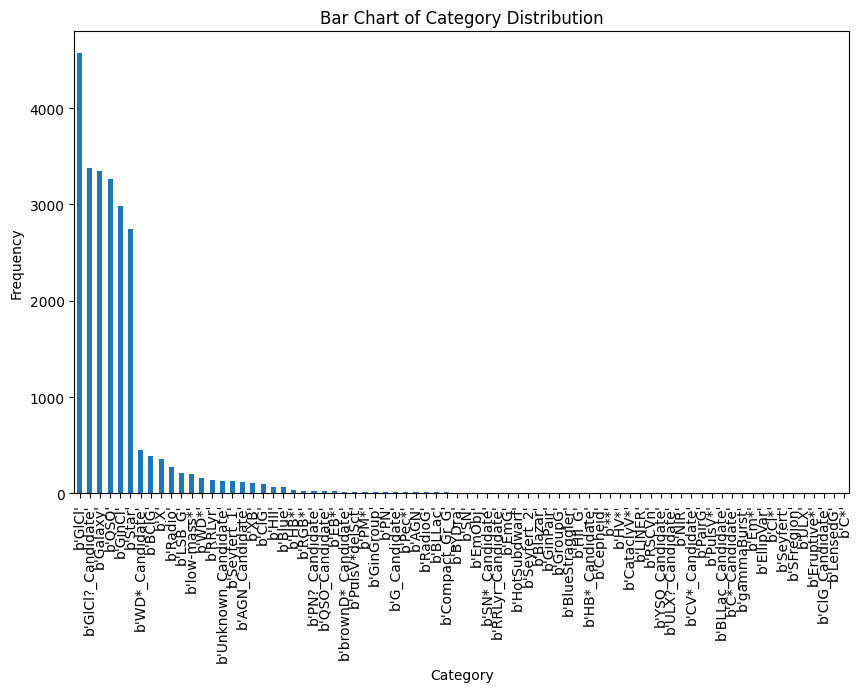

In [15]:
# Create and display the pie chart of the new column
category_counts = dft['main_type'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Bar Chart of Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

The number of different categories in the new grouped column: 10


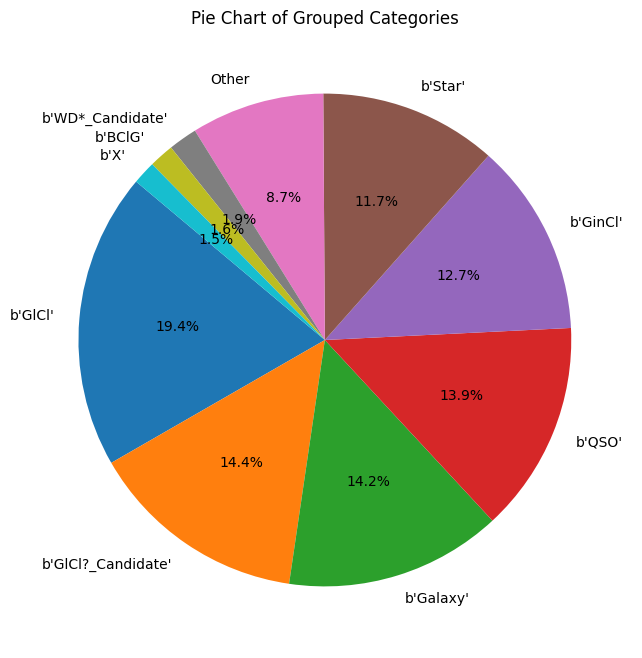

In [16]:
# Count the occurrences of each category
category_counts = dft['main_type'].value_counts()

# Specify the categorical column
category_column = 'main_type'

# Define the threshold for rare categories
threshold = 300  # Categories with counts less than or equal to this will be grouped into "Other"

# Count the occurrences of each category
category_counts = dft[category_column].value_counts()

# Identify the rare categories
rare_categories = category_counts[category_counts <= threshold].index

# Create a new column with grouped categories
dft['grouped_category'] = dft[category_column].apply(lambda x: 'Other' if x in rare_categories else x)

# Print the number of different categories in the new column
num_categories = dft['grouped_category'].nunique()
print(f'The number of different categories in the new grouped column: {num_categories}')



# Count the occurrences of each category
category_counts = dft['grouped_category'].value_counts()


# Create and display the pie chart of the new column
category_counts = dft['grouped_category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Grouped Categories')
plt.show()

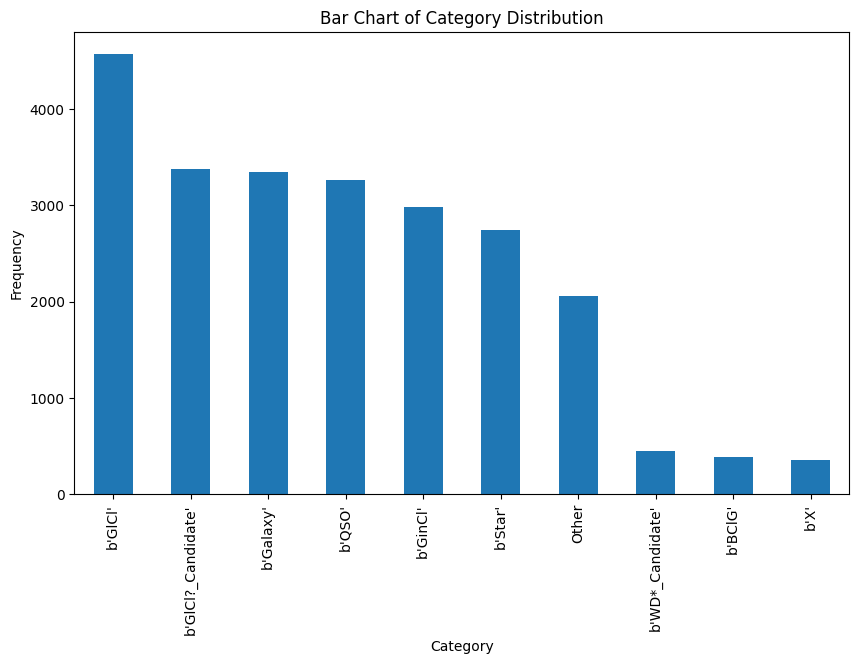

In [17]:
# Create a bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Bar Chart of Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [18]:
dft['grouped_category'].value_counts()

b'GlCl'               4568
b'GlCl?_Candidate'    3381
b'Galaxy'             3346
b'QSO'                3264
b'GinCl'              2980
b'Star'               2742
Other                 2056
b'WD*_Candidate'       445
b'BClG'                383
b'X'                   359
Name: grouped_category, dtype: int64

In [19]:
dft.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'p_star', 'p_gc', 'p_galx',
       'main_type', 'grouped_category'],
      dtype='object')

In [20]:
dft = dft.drop(columns='main_type')

In [21]:
# Get the unique types in the 'grouped_category' column
unique_types = dft['grouped_category'].apply(type).unique()
print("Different types in 'grouped_category' column:", unique_types)

Different types in 'grouped_category' column: [<class 'str'> <class 'bytes'>]


In [22]:
# Ensure all values in 'grouped_category' are strings
dft['grouped_category'] = dft['grouped_category'].astype(str)

In [23]:
df = dft.copy()

In [24]:
dft.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'p_star', 'p_gc', 'p_galx',
       'grouped_category'],
      dtype='object')

In [25]:
df.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'p_star', 'p_gc', 'p_galx',
       'grouped_category'],
      dtype='object')

In [26]:
from sklearn.preprocessing import LabelEncoder
# Label Encoding
label_encoder = LabelEncoder()
df['main_type_encoded'] = label_encoder.fit_transform(df['grouped_category'])

In [27]:
df.columns

Index(['elongation', 'umag', 'gmag', 'rmag', 'imag', 'zmag', 'ksmag', 'uerr',
       'gerr', 'rerr', 'ierr', 'zerr', 'kserr', 'iC', 'iCerr', 'ebv',
       'background_g', 'ug0', 'gi0', 'iz0', 'ik0', 'p_star', 'p_gc', 'p_galx',
       'grouped_category', 'main_type_encoded'],
      dtype='object')

/tmp/ipykernel_164757/3090682606.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


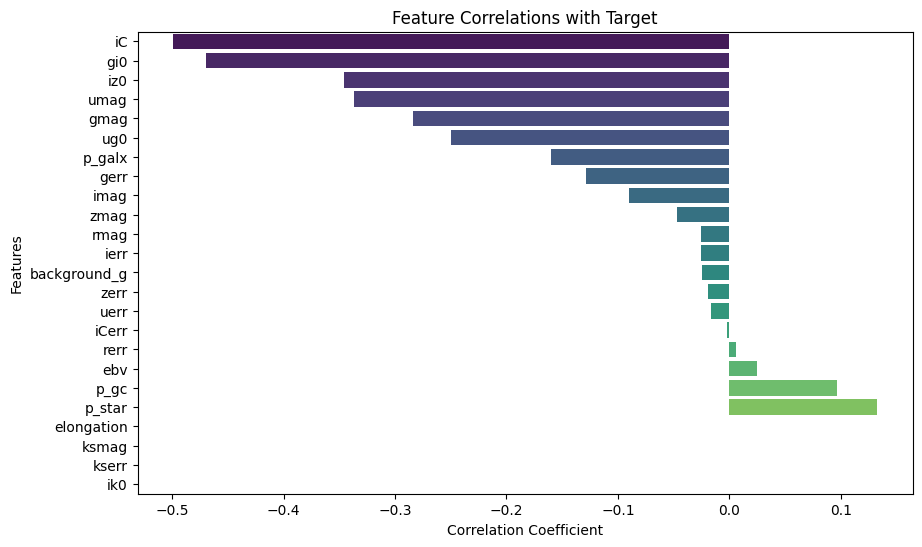

In [28]:
 # Calculate the correlation matrix
correlation_matrix = df.corr()

# Get the correlations of the features with the target
correlation_with_target = correlation_matrix['main_type_encoded'].drop('main_type_encoded')


# Sort correlations
sorted_correlations = correlation_with_target.sort_values()

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette="viridis")
plt.title('Feature Correlations with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

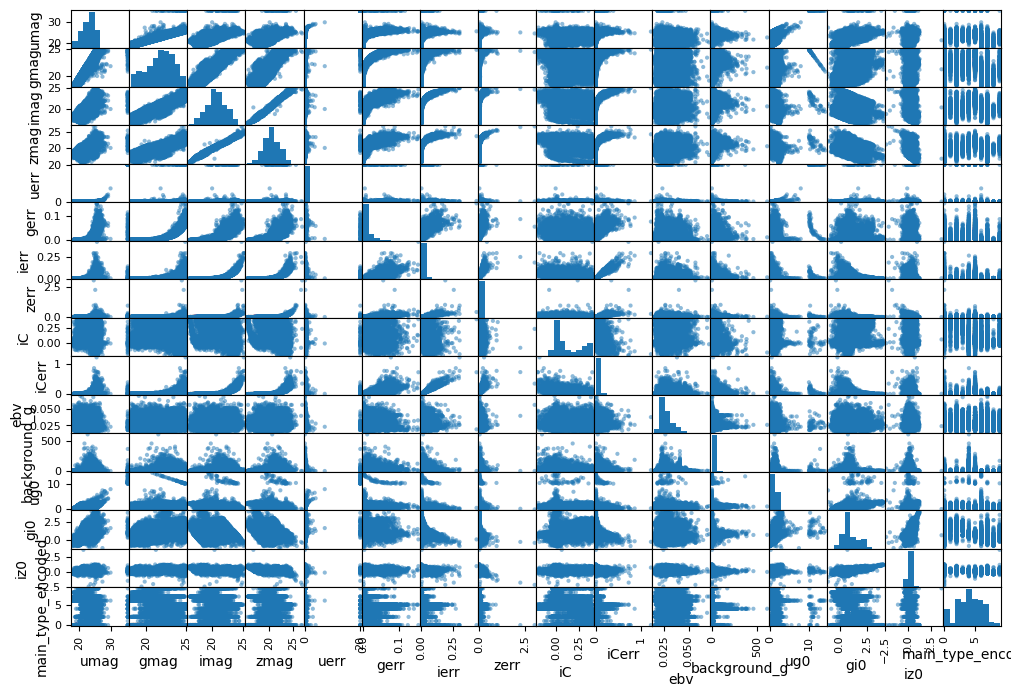

In [29]:
from pandas.plotting import scatter_matrix

attributes = [ 'umag', 'gmag', 'imag', 'zmag',
       'uerr', 'gerr', 'ierr', 'zerr', 'iC', 'iCerr', 'ebv', 'background_g',
       'ug0', 'gi0', 'iz0', 'main_type_encoded']
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

In [30]:
df = df.drop(columns=[ 'elongation','ik0' , 'ksmag', 'kserr', 'rmag', 'rerr', 'p_galx', 'p_star', 'p_gc', 'grouped_category'])

In [31]:
from tabulate import tabulate

# Print the DataFrame columns in a tabulated format
columns = df.columns.tolist()
print(tabulate([[col] for col in columns], headers=['Columns'], tablefmt='grid'))

+-------------------+
| Columns           |
+===================+
| umag              |
+-------------------+
| gmag              |
+-------------------+
| imag              |
+-------------------+
| zmag              |
+-------------------+
| uerr              |
+-------------------+
| gerr              |
+-------------------+
| ierr              |
+-------------------+
| zerr              |
+-------------------+
| iC                |
+-------------------+
| iCerr             |
+-------------------+
| ebv               |
+-------------------+
| background_g      |
+-------------------+
| ug0               |
+-------------------+
| gi0               |
+-------------------+
| iz0               |
+-------------------+
| main_type_encoded |
+-------------------+


In [32]:
# Save the train and test datasets to CSV files
df.to_csv('/home/samanehjavadinia/Co-op/Data/modified_dataset.csv', index=False)

In [33]:
#############LOading
###########
#######
#########
#########


In [34]:
# If you want to load the data later, you can use the following code
df = pd.read_csv('/home/samanehjavadinia/Co-op/Data/modified_dataset.csv')


In [35]:
df.columns

Index(['umag', 'gmag', 'imag', 'zmag', 'uerr', 'gerr', 'ierr', 'zerr', 'iC',
       'iCerr', 'ebv', 'background_g', 'ug0', 'gi0', 'iz0',
       'main_type_encoded'],
      dtype='object')

In [36]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['main_type_encoded'], random_state=42)
# Separate X and y for training and testing
X_train = train_df.drop(columns=['main_type_encoded'])
y_train = train_df['main_type_encoded']
X_test = test_df.drop(columns=['main_type_encoded'])
y_test = test_df['main_type_encoded']

In [37]:
X_train.head()

,umag,gmag,imag,zmag,uerr,gerr,ierr,zerr,iC,iCerr,ebv,background_g,ug0,gi0,iz0
1115,20.5504,19.9265,19.5725,19.4865,0.00495,0.00180,0.00225,0.00480,0.0001,0.005569,0.037,10.751000,0.589527,0.295429,0.068129
16685,25.1132,23.2397,21.1305,20.8807,0.11130,0.01755,0.00735,0.01380,0.3867,0.013685,0.029,0.280370,1.846559,2.063293,0.235793
1902,22.8807,21.2217,19.4354,19.0524,0.01680,0.00285,0.00255,0.00285,0.3972,0.004074,0.034,0.932446,1.627414,1.732478,0.366578
23009,19.1128,18.0507,17.3940,17.2959,0.00135,0.00060,0.00060,0.00090,0.0375,0.001352,0.031,1.930950,1.033301,0.607627,0.083127
19465,22.6826,20.7778,20.5138,20.5556,0.01350,0.00270,0.00510,0.00885,0.0407,0.010772,0.021,0.484835,1.885291,0.230757,-0.051943


In [38]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def scale_numeric_columns(train_df, test_df):
    # Identify non-numeric and numeric columns
    non_numeric_columns = train_df.select_dtypes(include=['object']).columns
    numeric_columns = train_df.select_dtypes(exclude=['object']).columns

    # Separate non-numeric and numeric columns
    train_non_numeric = train_df[non_numeric_columns]
    train_numeric = train_df[numeric_columns]

    test_non_numeric = test_df[non_numeric_columns]
    test_numeric = test_df[numeric_columns]

    # Handle missing values in numeric columns
    train_numeric = train_numeric.dropna()
    test_numeric = test_numeric.dropna()
    # Alternatively, fill missing values
    # train_numeric = train_numeric.fillna(train_numeric.mean())
    # test_numeric = test_numeric.fillna(test_numeric.mean())

    # Scale the numeric columns
    scaler = MinMaxScaler()
    train_numeric_scaled = scaler.fit_transform(train_numeric)
    test_numeric_scaled = scaler.transform(test_numeric)

    # Convert the scaled array back to DataFrames
    train_numeric_scaled = pd.DataFrame(train_numeric_scaled, columns=numeric_columns)
    test_numeric_scaled = pd.DataFrame(test_numeric_scaled, columns=numeric_columns)

    # Combine the scaled numeric columns with the non-numeric columns
    train_scaled = pd.concat([train_numeric_scaled, train_non_numeric.reset_index(drop=True)], axis=1)
    test_scaled = pd.concat([test_numeric_scaled, test_non_numeric.reset_index(drop=True)], axis=1)

    return train_scaled, test_scaled

# Example usage
# df = pd.read_csv('your_dataset.csv')  # Load your dataset
X_train_scaled, X_test_scaled = scale_numeric_columns(X_train, X_test)
# print("Scaled train data:", X_train_scaled.head())
# print("Scaled test data:", X_test_scaled.head())


In [39]:
X_train.head()

,umag,gmag,imag,zmag,uerr,gerr,ierr,zerr,iC,iCerr,ebv,background_g,ug0,gi0,iz0
1115,20.5504,19.9265,19.5725,19.4865,0.00495,0.00180,0.00225,0.00480,0.0001,0.005569,0.037,10.751000,0.589527,0.295429,0.068129
16685,25.1132,23.2397,21.1305,20.8807,0.11130,0.01755,0.00735,0.01380,0.3867,0.013685,0.029,0.280370,1.846559,2.063293,0.235793
1902,22.8807,21.2217,19.4354,19.0524,0.01680,0.00285,0.00255,0.00285,0.3972,0.004074,0.034,0.932446,1.627414,1.732478,0.366578
23009,19.1128,18.0507,17.3940,17.2959,0.00135,0.00060,0.00060,0.00090,0.0375,0.001352,0.031,1.930950,1.033301,0.607627,0.083127
19465,22.6826,20.7778,20.5138,20.5556,0.01350,0.00270,0.00510,0.00885,0.0407,0.010772,0.021,0.484835,1.885291,0.230757,-0.051943


########### Training on XGBoost
############
############
###########
###########

Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.34      0.42       411
           1       0.40      0.18      0.25        77
           2       0.65      0.61      0.63       669
           3       0.70      0.85      0.77       596
           4       0.76      0.87      0.81       914
           5       0.72      0.68      0.70       676
           6       0.81      0.88      0.84       653
           7       0.77      0.80      0.79       548
           8       0.55      0.51      0.53        89
           9       0.33      0.11      0.17        72

    accuracy                           0.72      4705
   macro avg       0.62      0.58      0.59      4705
weighted avg       0.70      0.72      0.71      4705

Label Mapping: {'Other': 0, "b'BClG'": 1, "b'Galaxy'": 2, "b'GinCl'": 3, "b'GlCl'": 4, "b'GlCl?_Candidate'": 5, "b'QSO'": 6, "b'Star'": 7, "b'WD*_Candidate'": 8, "b'X'": 9}
['Other', "b'BClG'", "b'Galaxy

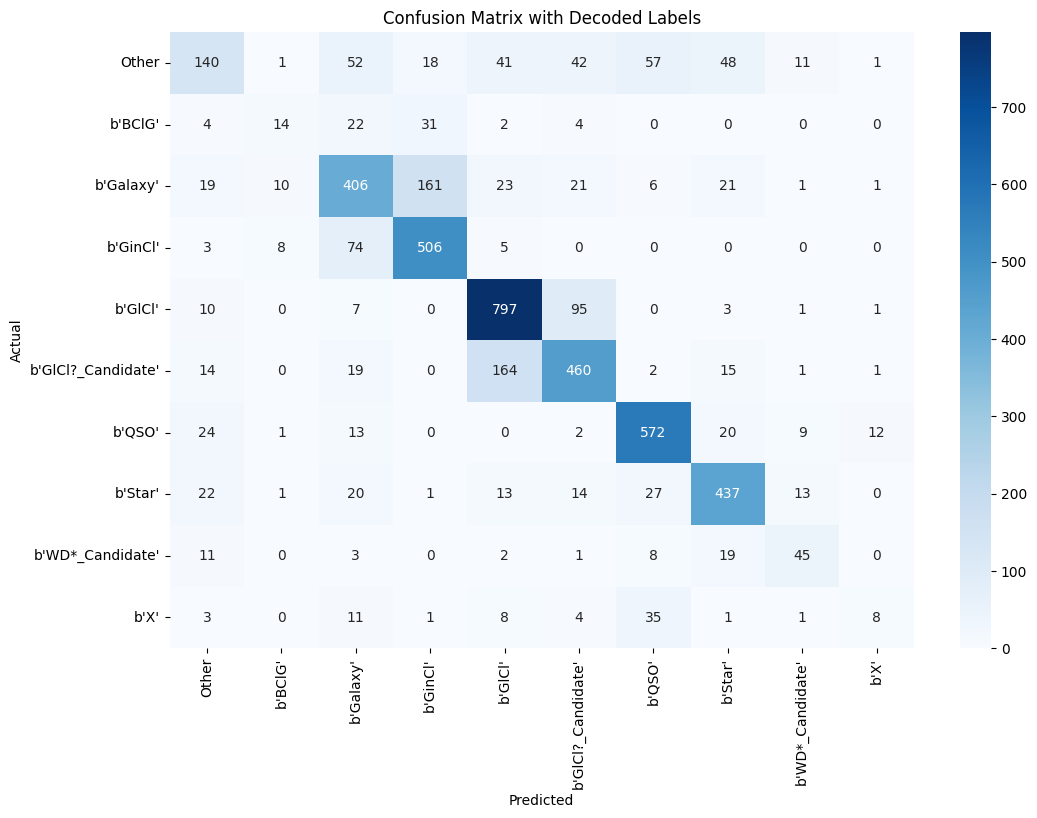

Model saved to xgboost_model.pkl


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import xgboost as xgb
# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Print the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Decode the labels using the dictionary
decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
print(decoded_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()

# Save the trained model to a file
model_filename = 'xgboost_model.pkl'
joblib.dump(xgb_classifier, model_filename)
print(f'Model saved to {model_filename}')

In [45]:
# Get the index of the label 'b'GlCl''
glcl_index = label_mapping["b'GlCl'"]

# Extract the row and column corresponding to 'b'GlCl'' in the confusion matrix
glcl_conf_matrix_row = conf_matrix[glcl_index, :]
glcl_conf_matrix_col = conf_matrix[:, glcl_index]

# Calculate the number of true positives, false positives, false negatives, and true negatives for 'b'GlCl''
true_positives_glcl = glcl_conf_matrix_row[glcl_index]
false_positives_glcl = sum(glcl_conf_matrix_col) - true_positives_glcl
false_negatives_glcl = sum(glcl_conf_matrix_row) - true_positives_glcl
true_negatives_glcl = np.sum(conf_matrix) - (true_positives_glcl + false_positives_glcl + false_negatives_glcl)

# Calculate the accuracy for 'b'GlCl''
accuracy_glcl = (true_positives_glcl + true_negatives_glcl) / np.sum(conf_matrix)

print(f'Number of correct predictions for label b\'GlCl\': {true_positives_glcl}')
print(f'Number of false predictions for label b\'GlCl\': {false_negatives_glcl + false_positives_glcl}')
print(f'Accuracy for label b\'GlCl\': {accuracy_glcl:.2f}')



Number of correct predictions for label b'GlCl': 797
Number of false predictions for label b'GlCl': 375
Accuracy for label b'GlCl': 0.92


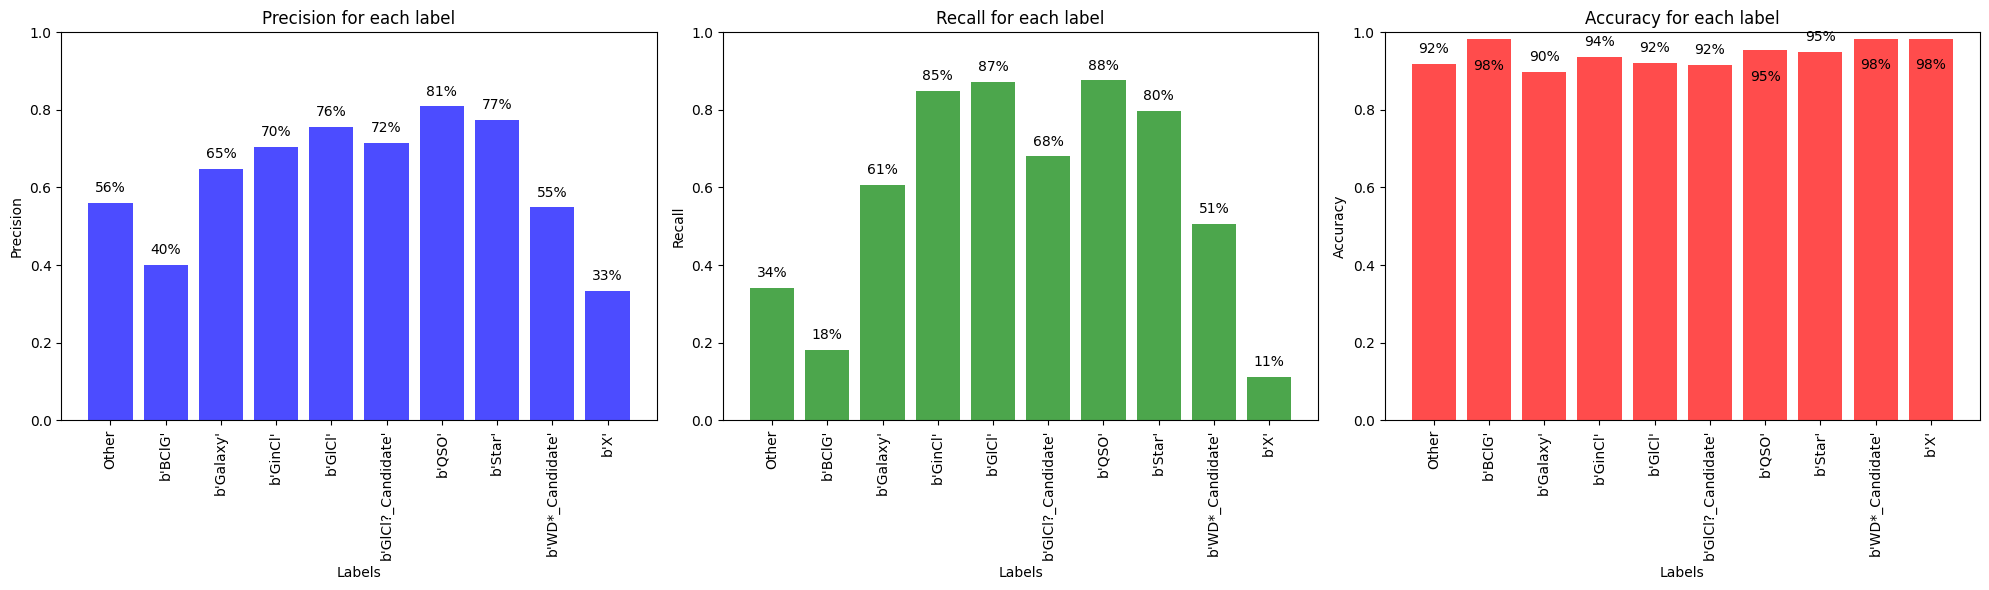

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming label_mapping and conf_matrix are already defined
# label_mapping = {'Other': 0, "b'BClG'": 1, "b'Galaxy'": 2, "b'GinCl'": 3, "b'GlCl'": 4, "b'GlCl?_Candidate'": 5, "b'QSO'": 6, "b'Star'": 7, "b'WD*_Candidate'": 8, "b'X'": 9}
# conf_matrix = ... (your confusion matrix)

# Initialize lists to store precision, recall, and accuracy for each label
precisions = []
recalls = []
accuracies = []

# Calculate precision, recall, and accuracy for each label
for label, index in label_mapping.items():
    # Extract the row and column corresponding to the current label in the confusion matrix
    conf_matrix_row = conf_matrix[index, :]
    conf_matrix_col = conf_matrix[:, index]

    # True Positives (TP): Diagonal element for the current label
    tp = conf_matrix_row[index]

    # False Positives (FP): Sum of the column for the current label excluding the diagonal element
    fp = sum(conf_matrix_col) - tp

    # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
    fn = sum(conf_matrix_row) - tp

    # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    precisions.append(precision)

    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    recalls.append(recall)

    # Calculate Accuracy
    accuracy = (tp + tn) / np.sum(conf_matrix)
    accuracies.append(accuracy)

# Plot Precision, Recall, and Accuracy for each label
labels = list(label_mapping.keys())
x = np.arange(len(labels))

plt.figure(figsize=(20, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Precision')
plt.title('Precision for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(precisions):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Recall')
plt.title('Recall for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(recalls):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

# Plot Accuracy
plt.subplot(1, 3, 3)
plt.bar(x, accuracies, color='r', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Accuracy')
plt.title('Accuracy for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(accuracies):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

plt.tight_layout()
plt.show()


########### Training on Random Forest
############
############
###########
###########

Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.32      0.42       411
           1       0.48      0.19      0.28        77
           2       0.66      0.57      0.61       669
           3       0.69      0.87      0.77       596
           4       0.74      0.87      0.80       914
           5       0.71      0.67      0.69       676
           6       0.78      0.89      0.83       653
           7       0.76      0.79      0.77       548
           8       0.64      0.55      0.59        89
           9       0.38      0.04      0.07        72

    accuracy                           0.72      4705
   macro avg       0.64      0.58      0.58      4705
weighted avg       0.70      0.72      0.70      4705

Label Mapping: {'Other': 0, "b'BClG'": 1, "b'Galaxy'": 2, "b'GinCl'": 3, "b'GlCl'": 4, "b'GlCl?_Candidate'": 5, "b'QSO'": 6, "b'Star'": 7, "b'WD*_Candidate'": 8, "b'X'": 9}
['Other', "b'BClG'", "b'Galaxy

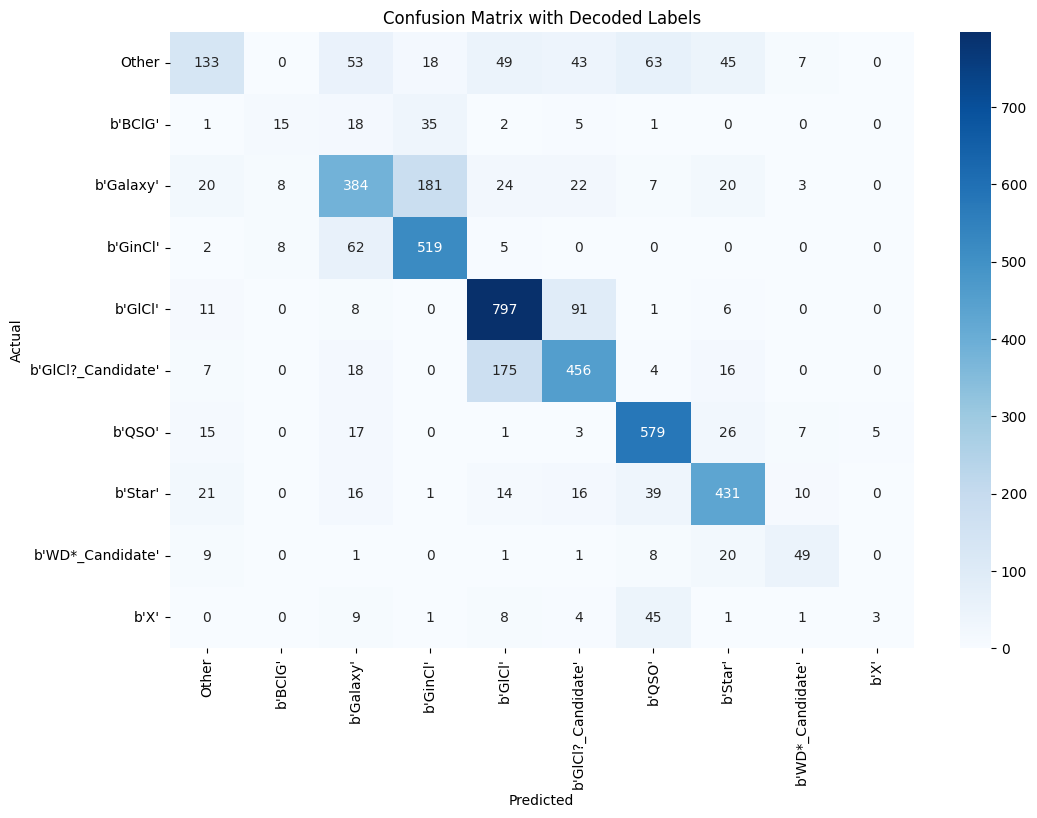

Model saved to random_forest_model.pkl


In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Print the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Decode the labels using the dictionary
decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
print(decoded_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()

# Save the trained model to a file
model_filename = 'random_forest_model.pkl'
joblib.dump(rf_classifier, model_filename)
print(f'Model saved to {model_filename}')

In [48]:
# Get the index of the label 'b'GlCl''
glcl_index = label_mapping["b'GlCl'"]

# Extract the row corresponding to 'b'GlCl'' in the confusion matrix
glcl_conf_matrix_row = conf_matrix[glcl_index, :]

# Calculate the number of false predictions for 'b'GlCl''
# This is the sum of all elements in the row excluding the diagonal element (which is the true positive count)
false_predictions_glcl = sum(glcl_conf_matrix_row) - glcl_conf_matrix_row[glcl_index]

print(f'Number of false predictions for label b\'GlCl\': {false_predictions_glcl}')


Number of false predictions for label b'GlCl': 117


In [50]:
#  Get the index of the label 'b'GlCl''
glcl_index = label_mapping["b'GlCl'"]

# Extract the row and column corresponding to 'b'GlCl'' in the confusion matrix
glcl_conf_matrix_row = conf_matrix[glcl_index, :]
glcl_conf_matrix_col = conf_matrix[:, glcl_index]

# Calculate the number of true positives, false positives, false negatives, and true negatives for 'b'GlCl''
true_positives_glcl = glcl_conf_matrix_row[glcl_index]
false_positives_glcl = sum(glcl_conf_matrix_col) - true_positives_glcl
false_negatives_glcl = sum(glcl_conf_matrix_row) - true_positives_glcl
true_negatives_glcl = np.sum(conf_matrix) - (true_positives_glcl + false_positives_glcl + false_negatives_glcl)

# Calculate the accuracy for 'b'GlCl''
accuracy_glcl = (true_positives_glcl + true_negatives_glcl) / np.sum(conf_matrix)

print(f'Number of correct predictions for label b\'GlCl\': {true_positives_glcl}')
print(f'Number of false predictions for label b\'GlCl\': {false_negatives_glcl + false_positives_glcl}')
print(f'Accuracy for label b\'GlCl\': {accuracy_glcl:.2f}')



Number of correct predictions for label b'GlCl': 797
Number of false predictions for label b'GlCl': 396
Accuracy for label b'GlCl': 0.92


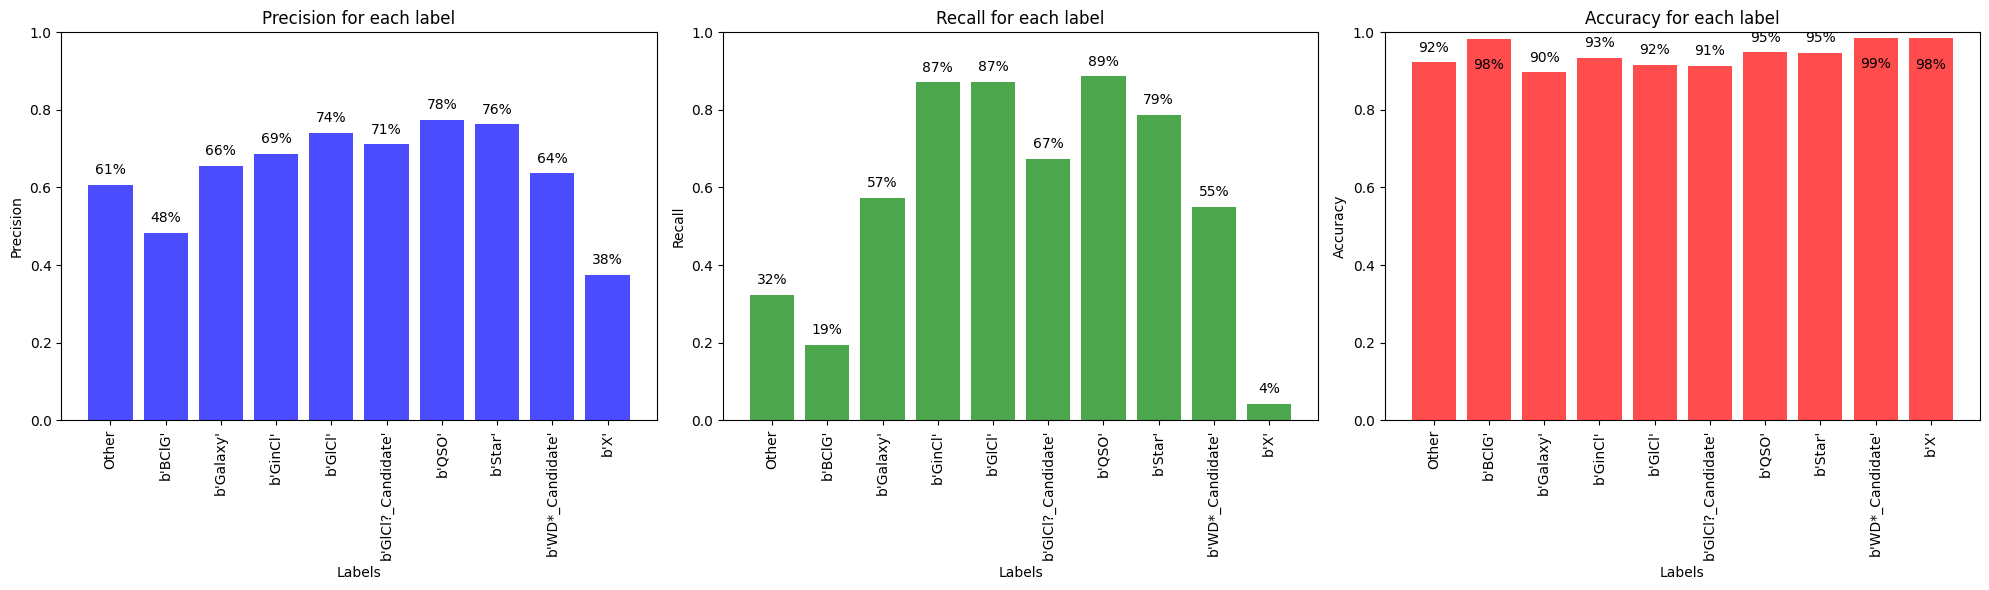

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming label_mapping and conf_matrix are already defined
# label_mapping = {'Other': 0, "b'BClG'": 1, "b'Galaxy'": 2, "b'GinCl'": 3, "b'GlCl'": 4, "b'GlCl?_Candidate'": 5, "b'QSO'": 6, "b'Star'": 7, "b'WD*_Candidate'": 8, "b'X'": 9}
# conf_matrix = ... (your confusion matrix)

# Initialize lists to store precision, recall, and accuracy for each label
precisions = []
recalls = []
accuracies = []

# Calculate precision, recall, and accuracy for each label
for label, index in label_mapping.items():
    # Extract the row and column corresponding to the current label in the confusion matrix
    conf_matrix_row = conf_matrix[index, :]
    conf_matrix_col = conf_matrix[:, index]

    # True Positives (TP): Diagonal element for the current label
    tp = conf_matrix_row[index]

    # False Positives (FP): Sum of the column for the current label excluding the diagonal element
    fp = sum(conf_matrix_col) - tp

    # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
    fn = sum(conf_matrix_row) - tp

    # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    precisions.append(precision)

    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    recalls.append(recall)

    # Calculate Accuracy
    accuracy = (tp + tn) / np.sum(conf_matrix)
    accuracies.append(accuracy)

# Plot Precision, Recall, and Accuracy for each label
labels = list(label_mapping.keys())
x = np.arange(len(labels))

plt.figure(figsize=(20, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Precision')
plt.title('Precision for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(precisions):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Recall')
plt.title('Recall for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(recalls):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

# Plot Accuracy
plt.subplot(1, 3, 3)
plt.bar(x, accuracies, color='r', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Accuracy')
plt.title('Accuracy for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(accuracies):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

plt.tight_layout()
plt.show()


#################### Making the distributions normal before training
####################

<Axes: >

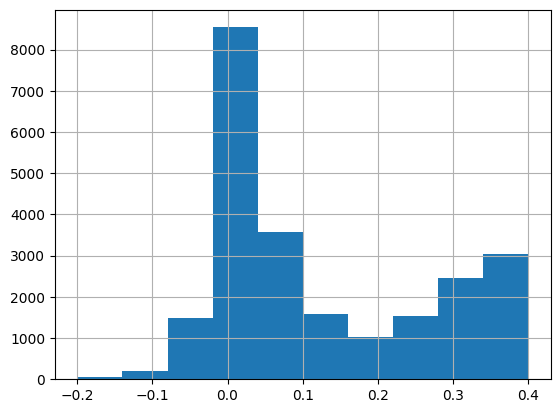

In [52]:
df['iC'].hist()

In [53]:
df.columns

Index(['umag', 'gmag', 'imag', 'zmag', 'uerr', 'gerr', 'ierr', 'zerr', 'iC',
       'iCerr', 'ebv', 'background_g', 'ug0', 'gi0', 'iz0',
       'main_type_encoded'],
      dtype='object')

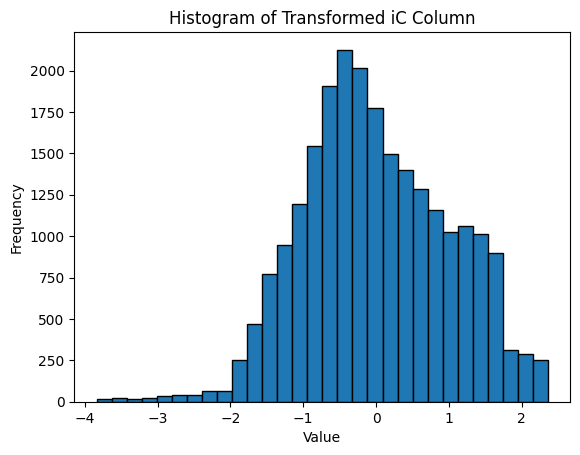

In [54]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox, zscore
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt



# Fit GMM
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(df[['iC']])  # Using double square brackets to keep it as a 2D array
labels = gmm.predict(df[['iC']])
df['mode_label'] = labels

# Apply transformations to each mode separately
transformed_columns = []
for label in np.unique(labels):
    mode_data = df[df['mode_label'] == label]['iC']
    
    # Apply a Box-Cox transformation (as an example)
    mode_data_transformed, _ = boxcox(mode_data - mode_data.min() + 1)  # Ensure positivity for Box-Cox
    
    # Normalize the transformed data to zero mean and unit variance
    mode_data_normalized = zscore(mode_data_transformed)
    
    # Store transformed and normalized data
    transformed_columns.append(pd.Series(mode_data_normalized, index=mode_data.index))

# Concatenate the transformed columns back into a single series
transformed_data = pd.concat(transformed_columns).sort_index()

# Plot the transformed data
plt.hist(transformed_data, bins=30, edgecolor='k')
plt.title('Histogram of Transformed iC Column')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Add the transformed data back to the DataFrame
df['transformed_iC'] = transformed_data

# # Display the DataFrame
# print(df.head())

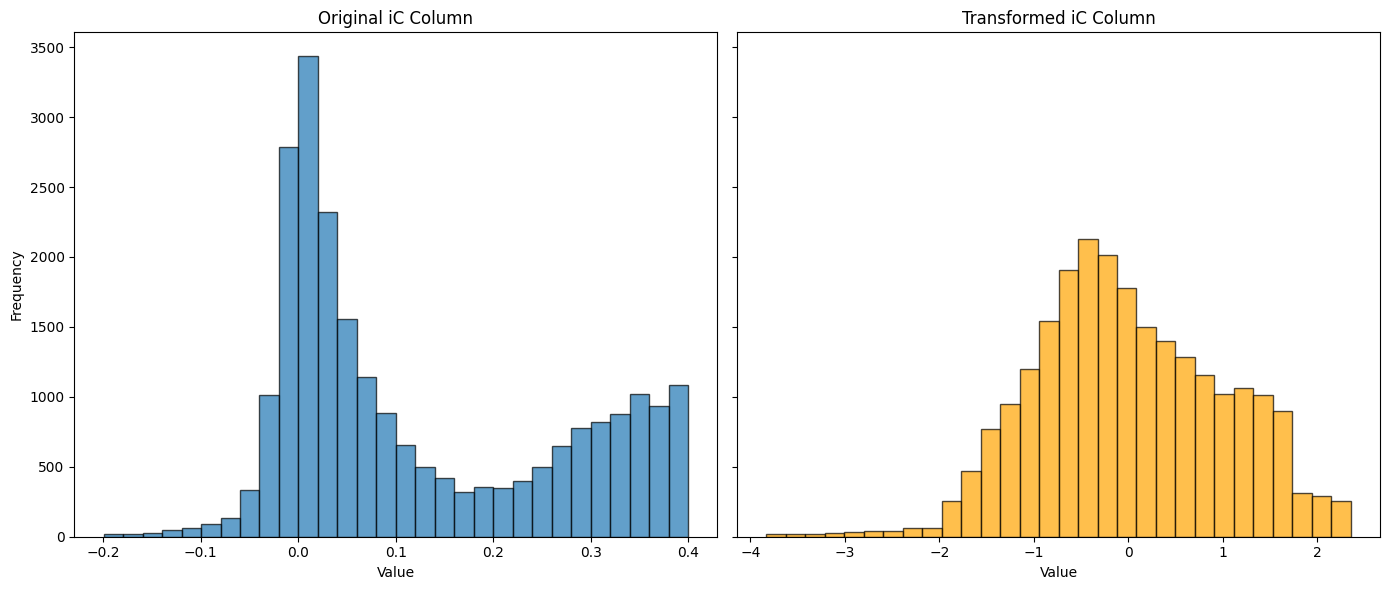

In [55]:

# Plot the original and transformed data histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original column histogram
axes[0].hist(df['iC'], bins=30, edgecolor='k', alpha=0.7)
axes[0].set_title('Original iC Column')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Transformed column histogram
axes[1].hist(df['transformed_iC'], bins=30, edgecolor='k', alpha=0.7, color='orange')
axes[1].set_title('Transformed iC Column')
axes[1].set_xlabel('Value')

plt.tight_layout()
plt.show()

In [56]:
df = df.drop(columns=['iC','mode_label'])


In [57]:
df.head()

,umag,gmag,imag,zmag,uerr,gerr,ierr,zerr,iCerr,ebv,background_g,ug0,gi0,iz0,main_type_encoded,transformed_iC
0,22.1789,21.5084,21.2657,21.4619,0.0102,0.00945,0.01110,0.04665,0.028564,0.025,0.473250,0.647275,0.203125,-0.208275,0,1.181767
1,20.5918,19.3795,18.5295,18.4378,0.0039,0.00180,0.00180,0.00330,0.004561,0.025,0.455295,1.189075,0.810425,0.079625,7,-0.546571
2,20.4290,20.3918,20.3615,20.2076,0.0036,0.00270,0.00420,0.01425,0.010423,0.027,0.226869,0.012117,-0.012441,0.140859,6,0.722034
3,24.0454,23.3085,21.4615,20.8710,0.0324,0.01830,0.00870,0.01365,0.017051,0.026,0.939378,0.712746,1.805842,0.577942,0,-1.102951
4,19.9847,19.4101,19.4011,19.3815,0.0027,0.00255,0.00405,0.00675,0.007558,0.028,0.698861,0.548588,-0.035324,0.006076,7,1.072879


In [58]:
df['iC'] = df['transformed_iC']
df = df.drop(columns='transformed_iC')

<Axes: >

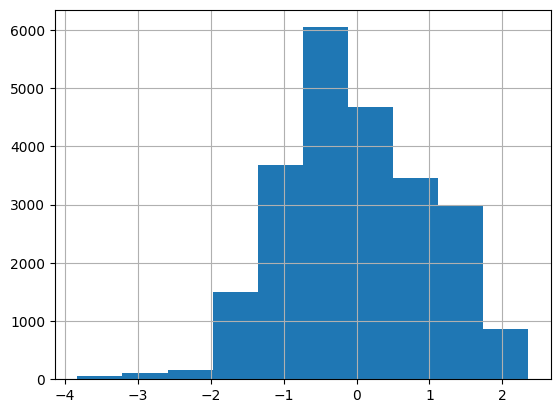

In [59]:
df['iC'].hist()

In [60]:
df.head()

,umag,gmag,imag,zmag,uerr,gerr,ierr,zerr,iCerr,ebv,background_g,ug0,gi0,iz0,main_type_encoded,iC
0,22.1789,21.5084,21.2657,21.4619,0.0102,0.00945,0.01110,0.04665,0.028564,0.025,0.473250,0.647275,0.203125,-0.208275,0,1.181767
1,20.5918,19.3795,18.5295,18.4378,0.0039,0.00180,0.00180,0.00330,0.004561,0.025,0.455295,1.189075,0.810425,0.079625,7,-0.546571
2,20.4290,20.3918,20.3615,20.2076,0.0036,0.00270,0.00420,0.01425,0.010423,0.027,0.226869,0.012117,-0.012441,0.140859,6,0.722034
3,24.0454,23.3085,21.4615,20.8710,0.0324,0.01830,0.00870,0.01365,0.017051,0.026,0.939378,0.712746,1.805842,0.577942,0,-1.102951
4,19.9847,19.4101,19.4011,19.3815,0.0027,0.00255,0.00405,0.00675,0.007558,0.028,0.698861,0.548588,-0.035324,0.006076,7,1.072879


In [61]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['main_type_encoded'], random_state=42)
# Separate X and y for training and testing
X_train = train_df.drop(columns=['main_type_encoded'])
y_train = train_df['main_type_encoded']
X_test = test_df.drop(columns=['main_type_encoded'])
y_test = test_df['main_type_encoded']

<Axes: >

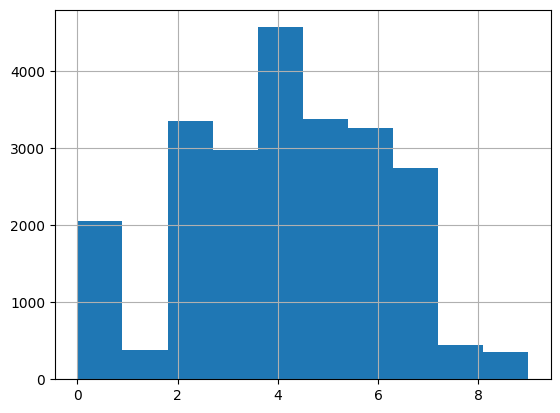

In [62]:
df['main_type_encoded'].hist()

<Axes: >

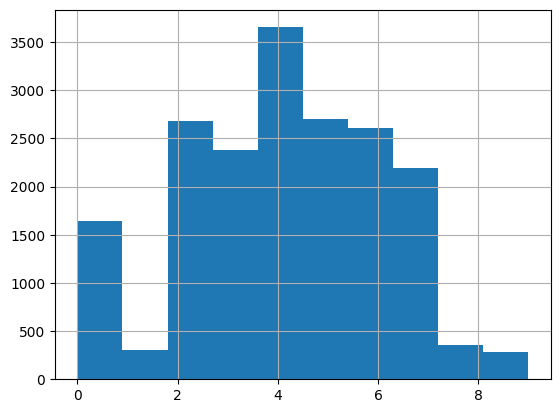

In [63]:
train_df['main_type_encoded'].hist()

<Axes: >

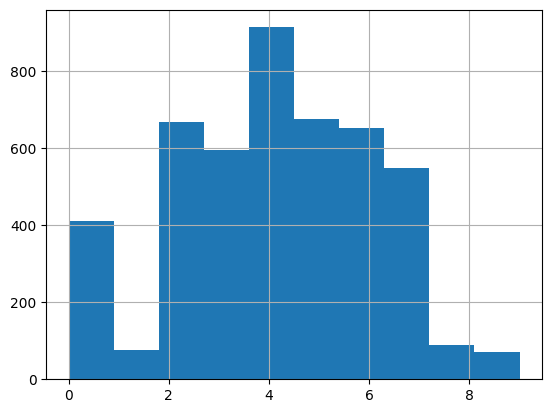

In [64]:
test_df['main_type_encoded'].hist()

In [65]:
train_df['main_type_encoded'].value_counts()/len(train_df['main_type_encoded'])

4    0.194165
5    0.143738
2    0.142250
6    0.138743
3    0.126680
7    0.116584
0    0.087412
8    0.018917
1    0.016260
9    0.015251
Name: main_type_encoded, dtype: float64

In [66]:
corr_matrix = train_df.corr()

In [67]:
corr_matrix['main_type_encoded'].sort_values(ascending=False)

main_type_encoded    1.000000
ebv                  0.024113
iCerr               -0.001149
uerr                -0.015105
zerr                -0.017309
background_g        -0.024529
ierr                -0.025870
zmag                -0.045635
imag                -0.088564
iC                  -0.101698
gerr                -0.127357
ug0                 -0.246949
gmag                -0.281981
umag                -0.334512
iz0                 -0.343355
gi0                 -0.468256
Name: main_type_encoded, dtype: float64

Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.29      0.39       411
           1       0.41      0.16      0.23        77
           2       0.61      0.56      0.59       669
           3       0.68      0.86      0.76       596
           4       0.74      0.87      0.80       914
           5       0.72      0.68      0.70       676
           6       0.77      0.89      0.82       653
           7       0.75      0.76      0.75       548
           8       0.69      0.58      0.63        89
           9       0.22      0.03      0.05        72

    accuracy                           0.71      4705
   macro avg       0.62      0.57      0.57      4705
weighted avg       0.69      0.71      0.69      4705

Label Mapping: {'Other': 0, "b'BClG'": 1, "b'Galaxy'": 2, "b'GinCl'": 3, "b'GlCl'": 4, "b'GlCl?_Candidate'": 5, "b'QSO'": 6, "b'Star'": 7, "b'WD*_Candidate'": 8, "b'X'": 9}
['Other', "b'BClG'", "b'Galaxy

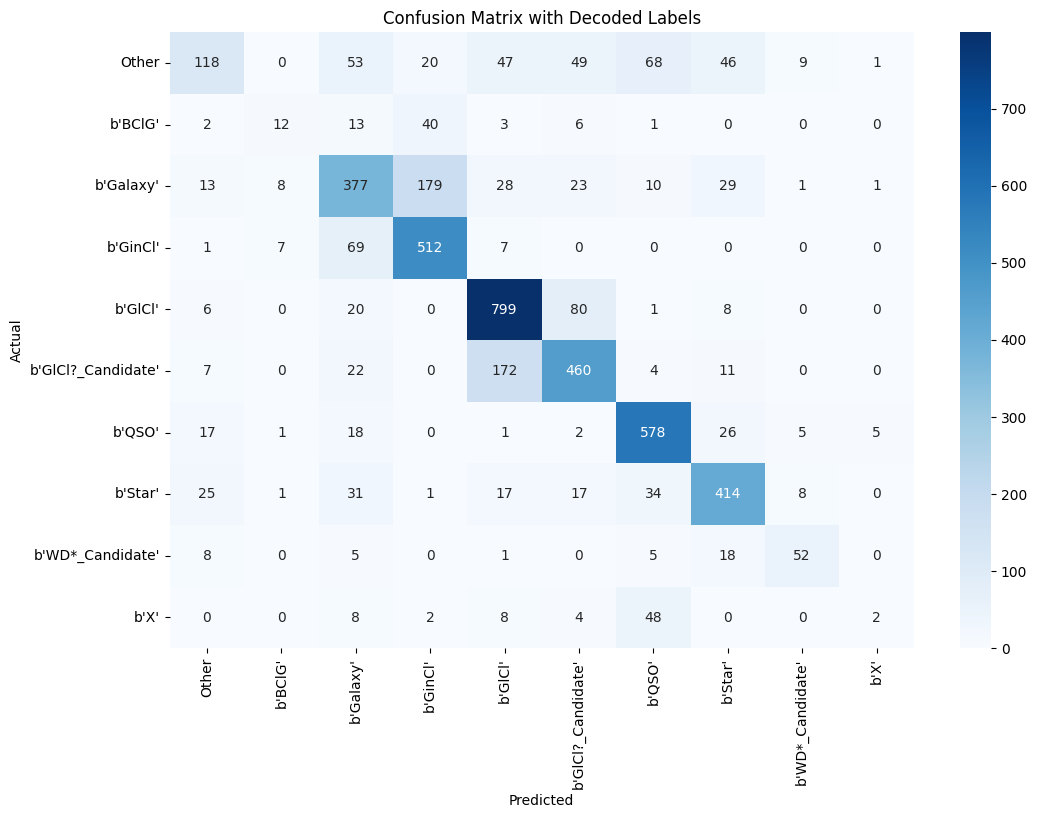

Model saved to random_forest_model_Modified.pkl


In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Print the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Decode the labels using the dictionary
decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
print(decoded_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()

# Save the trained model to a file
model_filename = 'random_forest_model_Modified.pkl'
joblib.dump(rf_classifier, model_filename)
print(f'Model saved to {model_filename}')

In [69]:
# Get the index of the label 'b'GlCl''
glcl_index = label_mapping["b'GlCl'"]

# Extract the row and column corresponding to 'b'GlCl'' in the confusion matrix
glcl_conf_matrix_row = conf_matrix[glcl_index, :]
glcl_conf_matrix_col = conf_matrix[:, glcl_index]

# Calculate the number of true positives, false positives, false negatives, and true negatives for 'b'GlCl''
true_positives_glcl = glcl_conf_matrix_row[glcl_index]
false_positives_glcl = sum(glcl_conf_matrix_col) - true_positives_glcl
false_negatives_glcl = sum(glcl_conf_matrix_row) - true_positives_glcl
true_negatives_glcl = np.sum(conf_matrix) - (true_positives_glcl + false_positives_glcl + false_negatives_glcl)

# Calculate the accuracy for 'b'GlCl''
accuracy_glcl = (true_positives_glcl + true_negatives_glcl) / np.sum(conf_matrix)

print(f'Number of correct predictions for label b\'GlCl\': {true_positives_glcl}')
print(f'Number of false predictions for label b\'GlCl\': {false_negatives_glcl + false_positives_glcl}')
print(f'Accuracy for label b\'GlCl\': {accuracy_glcl:.2f}')


Number of correct predictions for label b'GlCl': 799
Number of false predictions for label b'GlCl': 399
Accuracy for label b'GlCl': 0.92


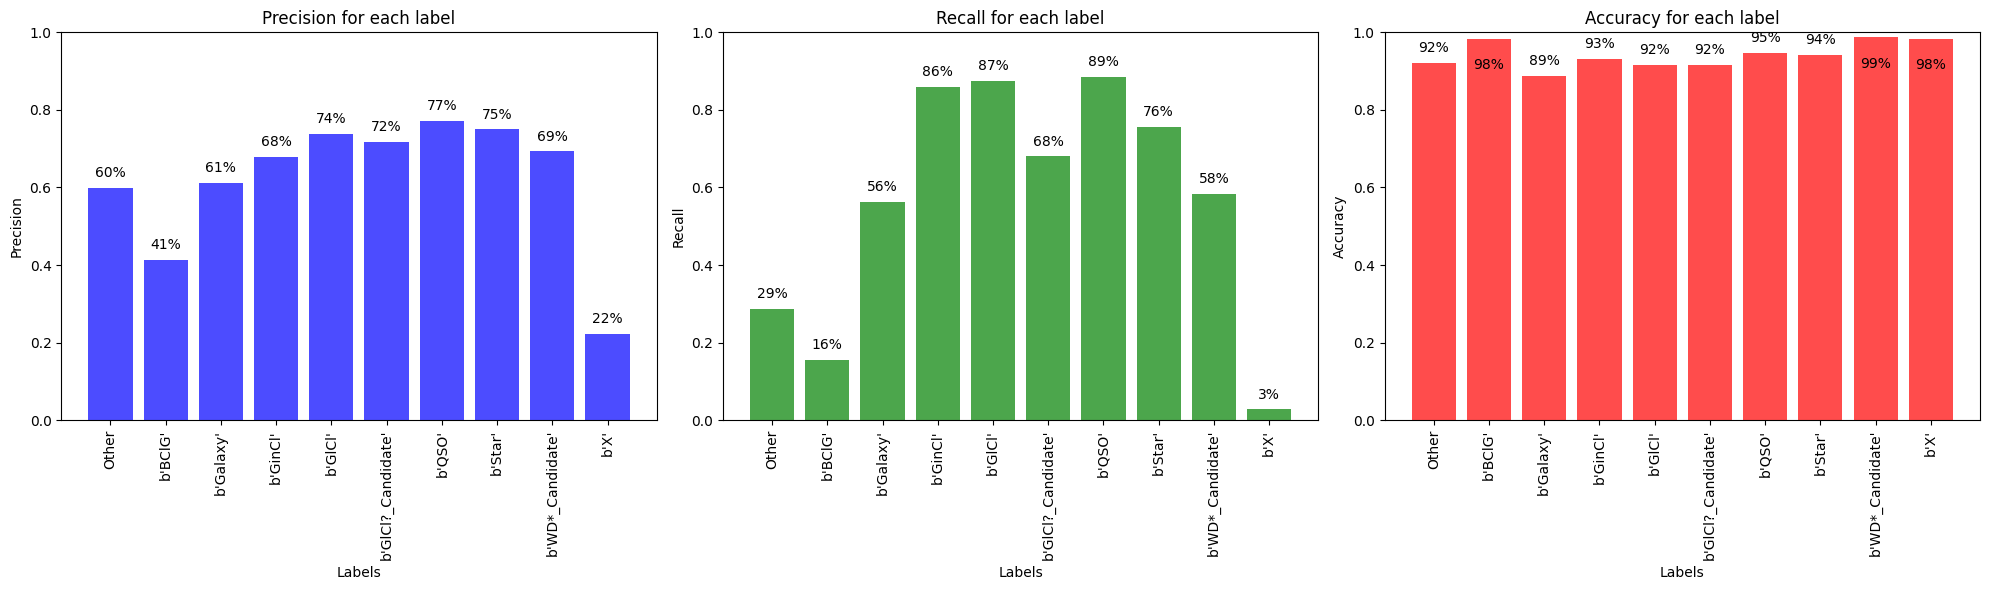

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming label_mapping and conf_matrix are already defined
# label_mapping = {'Other': 0, "b'BClG'": 1, "b'Galaxy'": 2, "b'GinCl'": 3, "b'GlCl'": 4, "b'GlCl?_Candidate'": 5, "b'QSO'": 6, "b'Star'": 7, "b'WD*_Candidate'": 8, "b'X'": 9}
# conf_matrix = ... (your confusion matrix)

# Initialize lists to store precision, recall, and accuracy for each label
precisions = []
recalls = []
accuracies = []

# Calculate precision, recall, and accuracy for each label
for label, index in label_mapping.items():
    # Extract the row and column corresponding to the current label in the confusion matrix
    conf_matrix_row = conf_matrix[index, :]
    conf_matrix_col = conf_matrix[:, index]

    # True Positives (TP): Diagonal element for the current label
    tp = conf_matrix_row[index]

    # False Positives (FP): Sum of the column for the current label excluding the diagonal element
    fp = sum(conf_matrix_col) - tp

    # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
    fn = sum(conf_matrix_row) - tp

    # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    precisions.append(precision)

    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    recalls.append(recall)

    # Calculate Accuracy
    accuracy = (tp + tn) / np.sum(conf_matrix)
    accuracies.append(accuracy)

# Plot Precision, Recall, and Accuracy for each label
labels = list(label_mapping.keys())
x = np.arange(len(labels))

plt.figure(figsize=(20, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Precision')
plt.title('Precision for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(precisions):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Recall')
plt.title('Recall for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(recalls):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

# Plot Accuracy
plt.subplot(1, 3, 3)
plt.bar(x, accuracies, color='r', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Accuracy')
plt.title('Accuracy for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(accuracies):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

plt.tight_layout()
plt.show()

##########Making another Feature to have normal distribution

<Axes: >

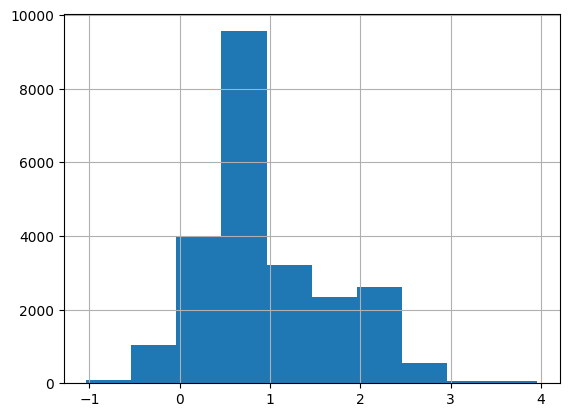

In [71]:
df['gi0'].hist()

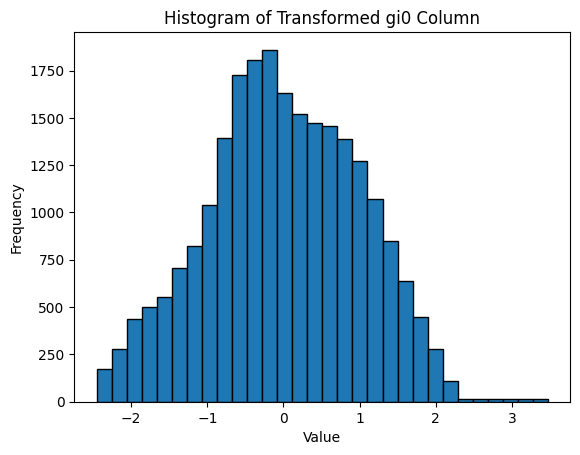

In [72]:
# Fit GMM
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(df[['gi0']])  # Using double square brackets to keep it as a 2D array
labels = gmm.predict(df[['gi0']])
df['mode_label'] = labels

# Apply transformations to each mode separately
transformed_columns = []
for label in np.unique(labels):
    mode_data = df[df['mode_label'] == label]['gi0']
    
    # Apply a Box-Cox transformation (as an example)
    mode_data_transformed, _ = boxcox(mode_data - mode_data.min() + 1)  # Ensure positivity for Box-Cox
    
    # Normalize the transformed data to zero mean and unit variance
    mode_data_normalized = zscore(mode_data_transformed)
    
    # Store transformed and normalized data
    transformed_columns.append(pd.Series(mode_data_normalized, index=mode_data.index))

# Concatenate the transformed columns back into a single series
transformed_data = pd.concat(transformed_columns).sort_index()

# Plot the transformed data
plt.hist(transformed_data, bins=30, edgecolor='k')
plt.title('Histogram of Transformed gi0 Column')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Add the transformed data back to the DataFrame
df['transformed_gi0'] = transformed_data


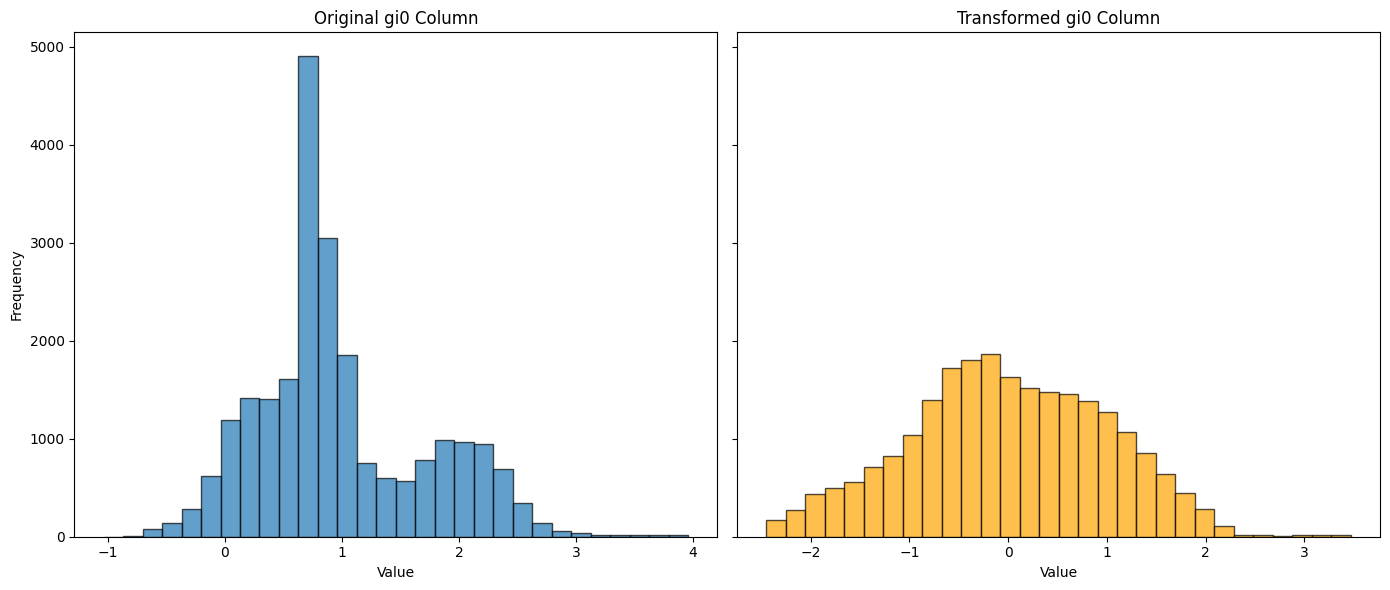

In [73]:
# Plot the original and transformed data histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original column histogram
axes[0].hist(df['gi0'], bins=30, edgecolor='k', alpha=0.7)
axes[0].set_title('Original gi0 Column')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Transformed column histogram
axes[1].hist(df['transformed_gi0'], bins=30, edgecolor='k', alpha=0.7, color='orange')
axes[1].set_title('Transformed gi0 Column')
axes[1].set_xlabel('Value')

plt.tight_layout()
plt.show()

In [74]:
df = df.drop(columns=['gi0','mode_label'])
df['gi0'] = df['transformed_gi0']
df = df.drop(columns='transformed_gi0')

<Axes: >

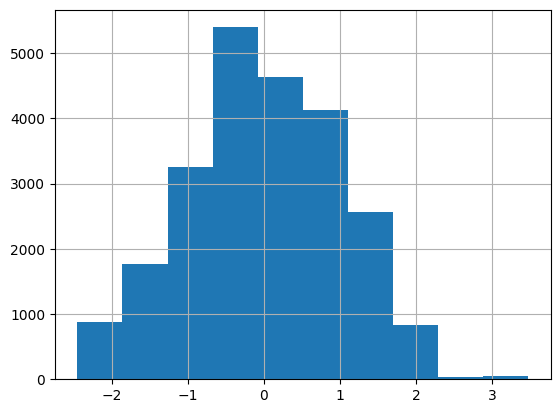

In [75]:
df['gi0'].hist()

In [76]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['main_type_encoded'], random_state=42)
# Separate X and y for training and testing
X_train = train_df.drop(columns=['main_type_encoded'])
y_train = train_df['main_type_encoded']
X_test = test_df.drop(columns=['main_type_encoded'])
y_test = test_df['main_type_encoded']

In [77]:
X_train.head()

,umag,gmag,imag,zmag,uerr,gerr,ierr,zerr,iCerr,ebv,background_g,ug0,iz0,iC,gi0
1115,20.5504,19.9265,19.5725,19.4865,0.00495,0.00180,0.00225,0.00480,0.005569,0.037,10.751000,0.589527,0.068129,-0.458970,0.810413
16685,25.1132,23.2397,21.1305,20.8807,0.11130,0.01755,0.00735,0.01380,0.013685,0.029,0.280370,1.846559,0.235793,1.364378,0.296083
1902,22.8807,21.2217,19.4354,19.0524,0.01680,0.00285,0.00255,0.00285,0.004074,0.034,0.932446,1.627414,0.366578,1.641294,-0.522893
23009,19.1128,18.0507,17.3940,17.2959,0.00135,0.00060,0.00060,0.00090,0.001352,0.031,1.930950,1.033301,0.083127,0.559044,-1.162820
19465,22.6826,20.7778,20.5138,20.5556,0.01350,0.00270,0.00510,0.00885,0.010772,0.021,0.484835,1.885291,-0.051943,0.653442,0.426364


<Axes: >

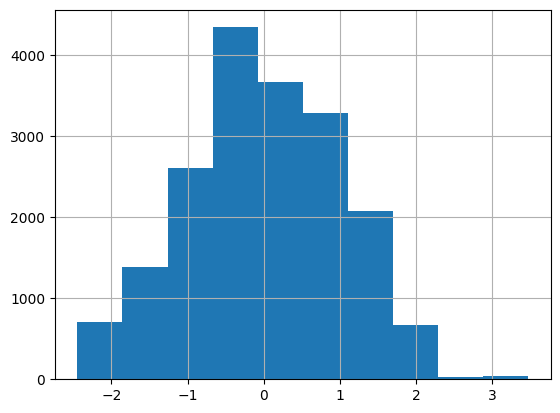

In [78]:
X_train['gi0'].hist()

Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.26      0.36       411
           1       0.41      0.14      0.21        77
           2       0.61      0.54      0.57       669
           3       0.68      0.85      0.75       596
           4       0.73      0.87      0.79       914
           5       0.72      0.68      0.70       676
           6       0.75      0.88      0.81       653
           7       0.74      0.76      0.75       548
           8       0.65      0.58      0.62        89
           9       0.25      0.03      0.05        72

    accuracy                           0.70      4705
   macro avg       0.61      0.56      0.56      4705
weighted avg       0.68      0.70      0.68      4705

Label Mapping: {'Other': 0, "b'BClG'": 1, "b'Galaxy'": 2, "b'GinCl'": 3, "b'GlCl'": 4, "b'GlCl?_Candidate'": 5, "b'QSO'": 6, "b'Star'": 7, "b'WD*_Candidate'": 8, "b'X'": 9}
['Other', "b'BClG'", "b'Galaxy

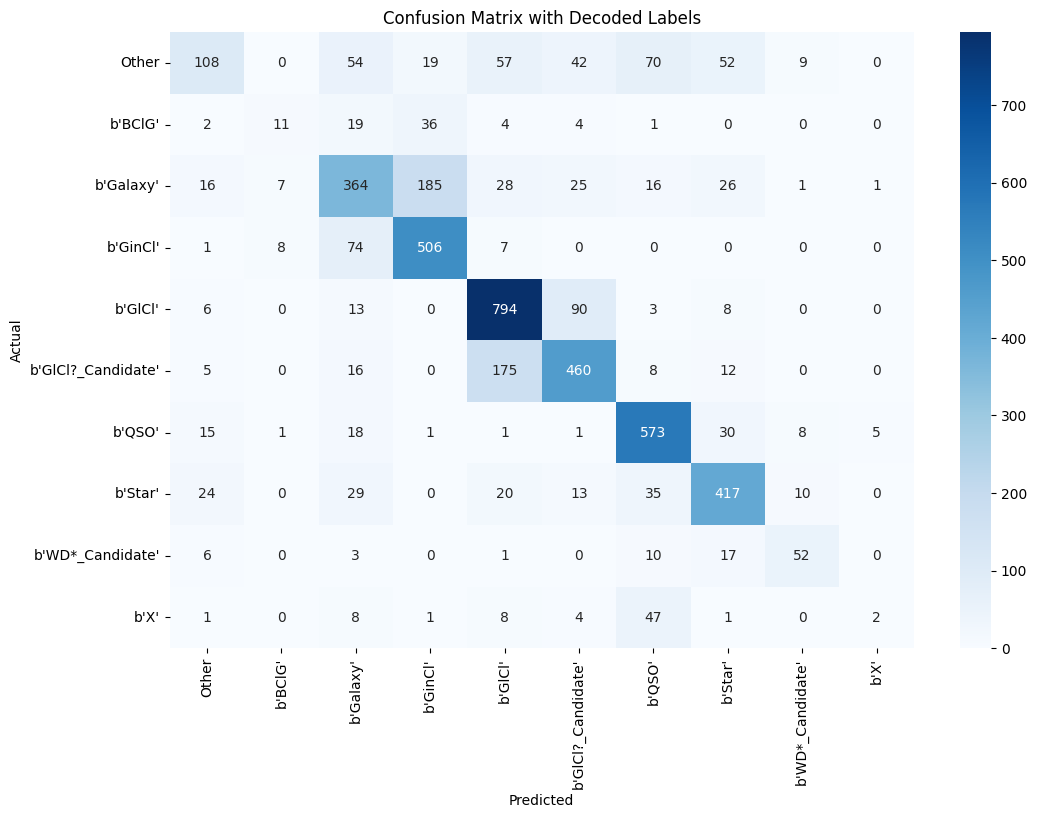

Model saved to second_random_forest_model_Modified.pkl


In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Print the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Decode the labels using the dictionary
decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
print(decoded_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Decoded Labels')
plt.show()

# Save the trained model to a file
model_filename = 'second_random_forest_model_Modified.pkl'
joblib.dump(rf_classifier, model_filename)
print(f'Model saved to {model_filename}')

In [80]:
# Print the mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Other': 0, "b'BClG'": 1, "b'Galaxy'": 2, "b'GinCl'": 3, "b'GlCl'": 4, "b'GlCl?_Candidate'": 5, "b'QSO'": 6, "b'Star'": 7, "b'WD*_Candidate'": 8, "b'X'": 9}


In [81]:
#  Get the index of the label 'b'GlCl''
glcl_index = label_mapping["b'GlCl'"]

# Extract the row and column corresponding to 'b'GlCl'' in the confusion matrix
glcl_conf_matrix_row = conf_matrix[glcl_index, :]
glcl_conf_matrix_col = conf_matrix[:, glcl_index]

# Calculate the number of true positives, false positives, false negatives, and true negatives for 'b'GlCl''
true_positives_glcl = glcl_conf_matrix_row[glcl_index]
false_positives_glcl = sum(glcl_conf_matrix_col) - true_positives_glcl
false_negatives_glcl = sum(glcl_conf_matrix_row) - true_positives_glcl
true_negatives_glcl = np.sum(conf_matrix) - (true_positives_glcl + false_positives_glcl + false_negatives_glcl)

# Calculate the accuracy for 'b'GlCl''
accuracy_glcl = (true_positives_glcl + true_negatives_glcl) / np.sum(conf_matrix)

print(f'Number of correct predictions for label b\'GlCl\': {true_positives_glcl}')
print(f'Number of false predictions for label b\'GlCl\': {false_negatives_glcl + false_positives_glcl}')
print(f'Accuracy for label b\'GlCl\': {accuracy_glcl:.2f}')



Number of correct predictions for label b'GlCl': 794
Number of false predictions for label b'GlCl': 421
Accuracy for label b'GlCl': 0.91


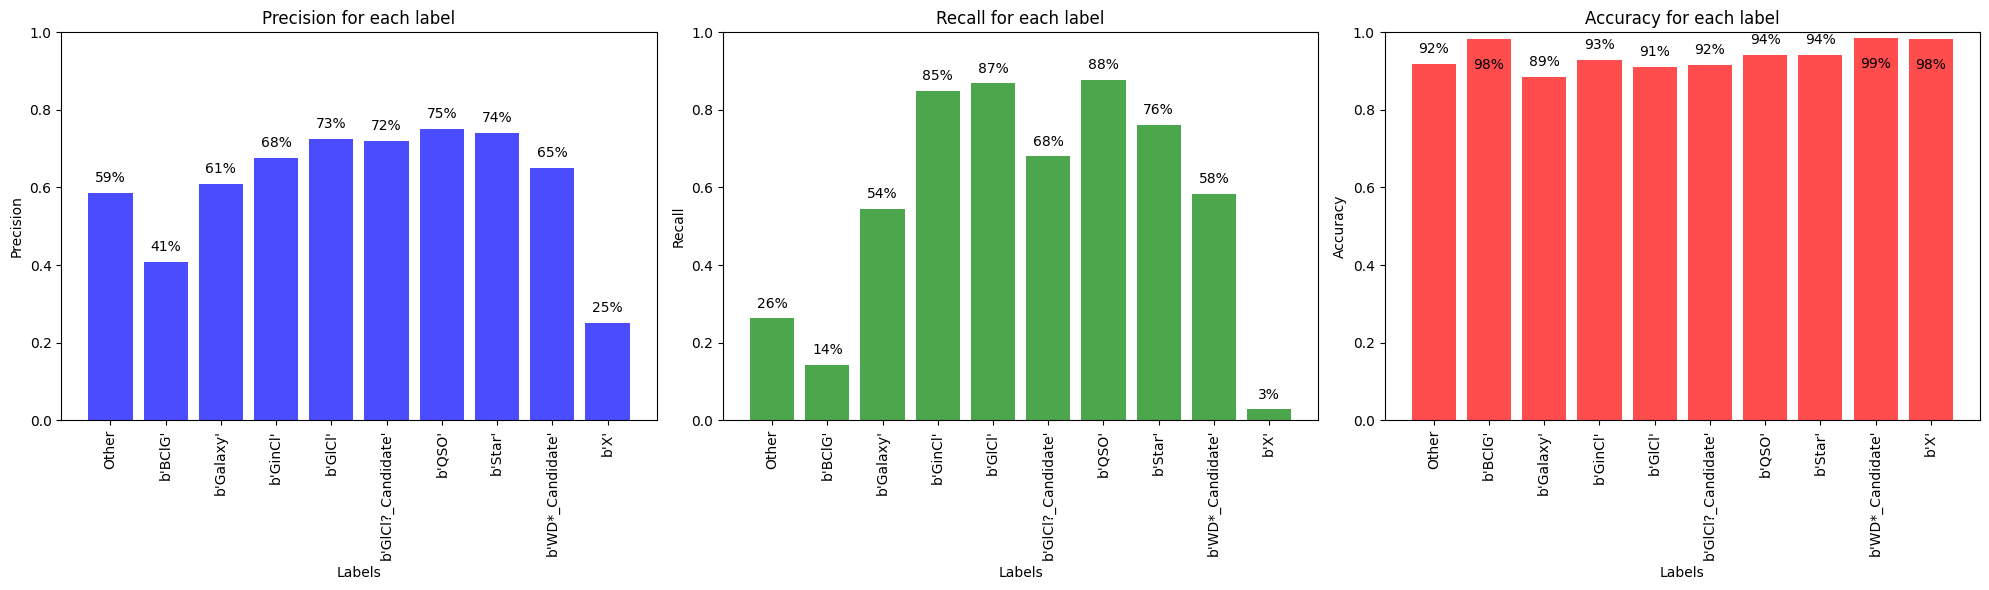

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming label_mapping and conf_matrix are already defined
# label_mapping = {'Other': 0, "b'BClG'": 1, "b'Galaxy'": 2, "b'GinCl'": 3, "b'GlCl'": 4, "b'GlCl?_Candidate'": 5, "b'QSO'": 6, "b'Star'": 7, "b'WD*_Candidate'": 8, "b'X'": 9}
# conf_matrix = ... (your confusion matrix)

# Initialize lists to store precision, recall, and accuracy for each label
precisions = []
recalls = []
accuracies = []

# Calculate precision, recall, and accuracy for each label
for label, index in label_mapping.items():
    # Extract the row and column corresponding to the current label in the confusion matrix
    conf_matrix_row = conf_matrix[index, :]
    conf_matrix_col = conf_matrix[:, index]

    # True Positives (TP): Diagonal element for the current label
    tp = conf_matrix_row[index]

    # False Positives (FP): Sum of the column for the current label excluding the diagonal element
    fp = sum(conf_matrix_col) - tp

    # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
    fn = sum(conf_matrix_row) - tp

    # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # Calculate Precision
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    precisions.append(precision)

    # Calculate Recall
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    recalls.append(recall)

    # Calculate Accuracy
    accuracy = (tp + tn) / np.sum(conf_matrix)
    accuracies.append(accuracy)

# Plot Precision, Recall, and Accuracy for each label
labels = list(label_mapping.keys())
x = np.arange(len(labels))

plt.figure(figsize=(20, 6))

# Plot Precision
plt.subplot(1, 3, 1)
plt.bar(x, precisions, color='b', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Precision')
plt.title('Precision for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(precisions):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

# Plot Recall
plt.subplot(1, 3, 2)
plt.bar(x, recalls, color='g', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Recall')
plt.title('Recall for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(recalls):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

# Plot Accuracy
plt.subplot(1, 3, 3)
plt.bar(x, accuracies, color='r', alpha=0.7)
plt.xticks(x, labels, rotation=90)
plt.xlabel('Labels')
plt.ylabel('Accuracy')
plt.title('Accuracy for each label')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
for i, v in enumerate(accuracies):
    plt.text(i, v - 0.05 if v > 0.95 else v + 0.02, f'{v:.0%}', ha='center', va='bottom' if v <= 0.95 else 'top', color='black')

plt.tight_layout()
plt.show()


############end